## **DWT、SWT 應用在橋梁訊號上**

Use a Multiple Resolution to Decompose Signal

**分析分解後的cA(低頻)、cD(高頻) 訊號**

In [128]:
from numpy.fft import fft
import pywt
import os
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [129]:
def ListofFiles(Dir):
    '''紀錄該資料夾下包含所以子目錄下的檔案
    args :
        Dir : 根目錄資料夾路徑

    return :
        Files : 根目錄資料夾下包含所有子目錄的檔案路徑
    '''
    Files = []

    for root, dir_name, file_name in os.walk(Dir):
        for name in file_name:
            fullName = os.path.join(root, name)
            Files.append(fullName)
    return Files

### **讀取"橋梁模型" 訊號**

In [130]:
proDir = os.path.abspath(r'D:\bridge\bridge_ini')
configPath = os.path.join(proDir, "config_bridge_predictionV3_2.ini")
conf = configparser.ConfigParser()
conf.read(configPath, encoding="utf-8")

folderName1 = conf.get("Sensor Location", "sensor location")
folderName2 = conf.get("Sensor Location", "sensor location2")
bridgeSensor1 = r'D:\bridge\data\NanmenBridge\103'
bridgeSensor2 = r'D:\bridge\sensor_data\40'
modelPath = r'D:\bridge\NanmenBridge\model\103\bridge deck1_1_AutoEncoderModel_freq_125.h5'
axis = str(conf.get("Axis", "axis"))
method = conf.get("Method", "method")

In [131]:
# 文件設置 (找最新文件路徑)
SensorDataList = ListofFiles(bridgeSensor1)
SensorDataList.sort()
latest_data_path = SensorDataList[5]

#  資料前處理
df_bridge_data = pd.read_csv(latest_data_path, sep = ',')
BridgeDataOfAxis = np.array(df_bridge_data[axis]) # 此處指定axis = accY -> Y軸的時域信號值
BridgeDataOfAxis = BridgeDataOfAxis - np.mean(BridgeDataOfAxis) # 減去平均值 -> 去掉DC(頻率 = 0)的訊號
print(BridgeDataOfAxis.shape)

# 定義時域, 頻域座標 t-domain, f-domain
sample_rate = 1000 # 取樣頻率 [pts/sec]
N = len(BridgeDataOfAxis)
t_domain = np.arange(N) * (1/sample_rate) 
f_d = sample_rate / N # 頻域取樣間隔 f_d = 1/Nd = fs/N
f_domain = np.arange(N) * f_d



(20000,)


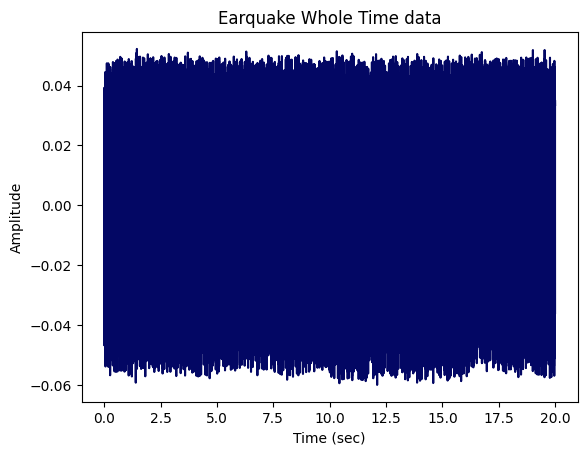

In [132]:
# 畫出時域訊號
plt.plot(t_domain, BridgeDataOfAxis, color= 'xkcd:darkblue')
plt.title("Earquake Whole Time data")
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.show()

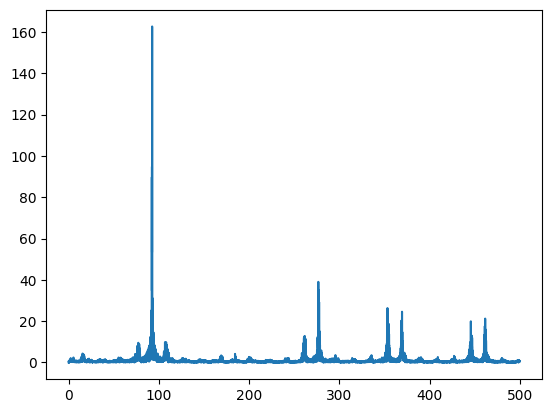

In [133]:
# 劃出頻域訊號
BridgeDataOfAxis_FFT = fft(BridgeDataOfAxis)
BridgeDataOfAxis_FFT = abs(BridgeDataOfAxis_FFT[:int(len(BridgeDataOfAxis)/2)])

plt.plot(f_domain[:int(len(BridgeDataOfAxis)/2)], BridgeDataOfAxis_FFT)

### **多層DWT小波轉換 (DB小波基)**

coeffs : cA_n, cD_n, cD_(n-1), ..., cD_1

3
[array([-0.05168389, -0.00141826,  0.03016767, ...,  0.04484736,
       -0.0598167 ,  0.05094892]), array([ 0.02121875, -0.01501563,  0.04094531, ..., -0.0003125 ,
        0.00327344, -0.00208594]), array([ 3.31456304e-05,  1.44404463e-02, -2.97095334e-02, ...,
        6.55178627e-03,  1.51144074e-02, -9.88844639e-03])]
cA2.shape = (5000,)
cD2.shape = (5000,)
cD1.shape = (10000,)


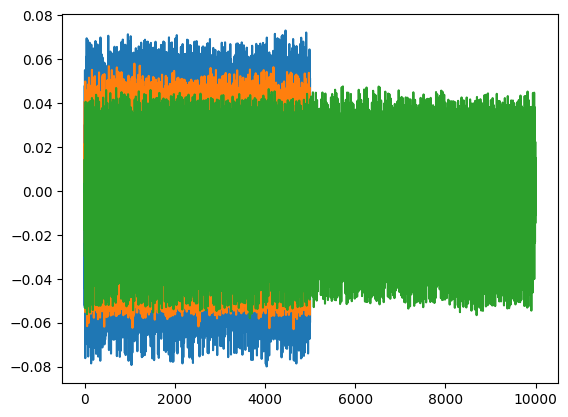

In [134]:
coeffs = pywt.wavedec(BridgeDataOfAxis, 'haar', level= 2) # DWT ， 二層分解， mode = periodic - 週期性的訊號 (∵訊號對稱)

print(len(coeffs))
print(coeffs)
cA2, cD2, cD1 = coeffs

print('cA2.shape =', cA2.shape)
print('cD2.shape =', cD2.shape)
print('cD1.shape =', cD1.shape)


plt.plot(cA2)
plt.plot(cD2)
plt.plot(cD1)

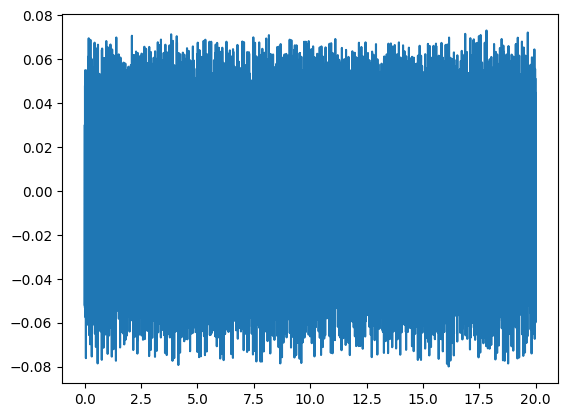

In [135]:


t_domain_level2 = np.arange(N/(2 *2)) * ((2 * 2) / (sample_rate))
plt.plot(t_domain_level2,cA2)


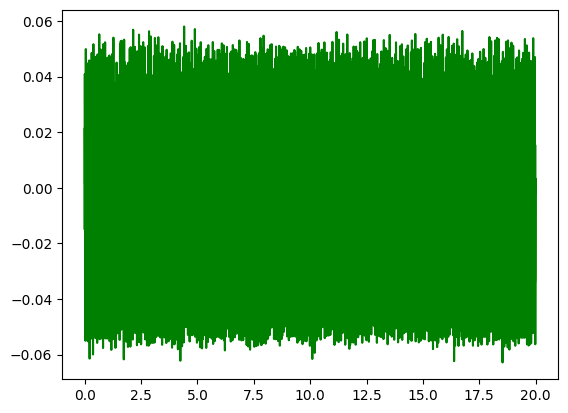

In [136]:
t_domain_level2 = np.arange(N/(2 *2)) * ((2 * 2) / (sample_rate))
plt.plot(t_domain_level2, cD2,'g')


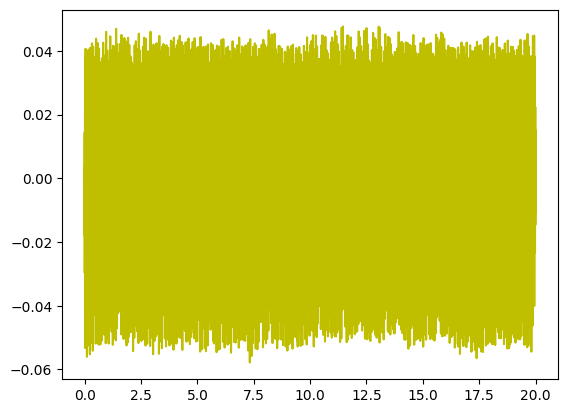

In [137]:
t_domain_level1 = np.arange(N/(2 *1)) * ((2 * 1) / (sample_rate))
plt.plot(t_domain_level1, cD1,'y')

(5000,)
(2500,)
(2500,)


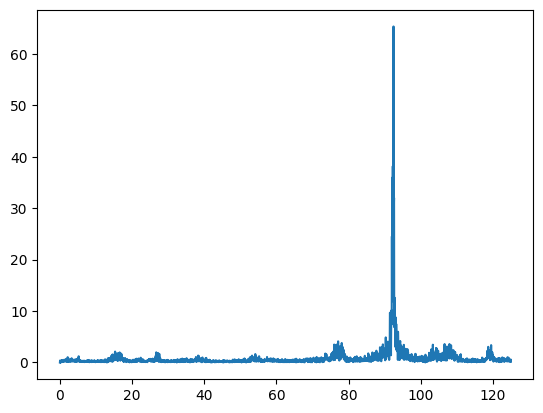

In [138]:
print(cA2.shape)
cA2_FFT = fft(cA2)
cA2_FFT = abs(cA2_FFT[:int(len(cA2)/2)]) # FFT 後取正頻率(一半)
# 降取樣 -> fs 下降 -> 頻域範圍下降 -> 點數也下降 -> ∴ 降取樣過程 : 頻域取樣間隔 f_d = fs/2/N/2 = fs/N 不變
f_d_level2 = sample_rate  / (2 * 2 ) / (len(cA2)) # 降取樣後的取樣頻率 fs/(2*2) / 降取樣後點數 len(cA2)
f_domain_level2 = np.arange(int(len(cA2)/2)) * f_d_level2

print(cA2_FFT.shape)
print(f_domain_level2.shape)
plt.plot(f_domain_level2,cA2_FFT)

(5000,)
(2500,)


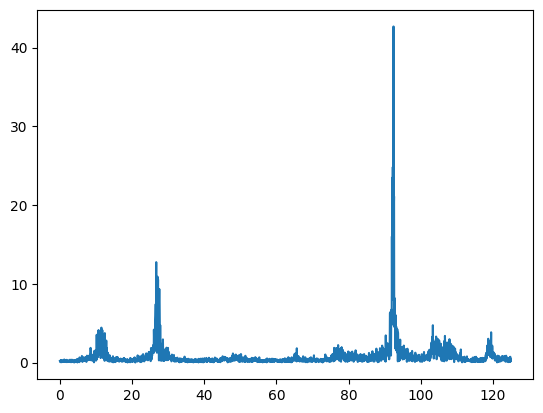

In [139]:
print(cD2.shape)
cD2_FFT = fft(cD2)
cD2_FFT = abs(cD2_FFT[:int(len(cD2_FFT)/2)])
f_d_level2 = f_d
f_domain_level2 = np.arange(int(len(cD2)/2)) * f_d

print(cD2_FFT.shape)
plt.plot(f_domain_level2,cD2_FFT)

(10000,)
(5000,)


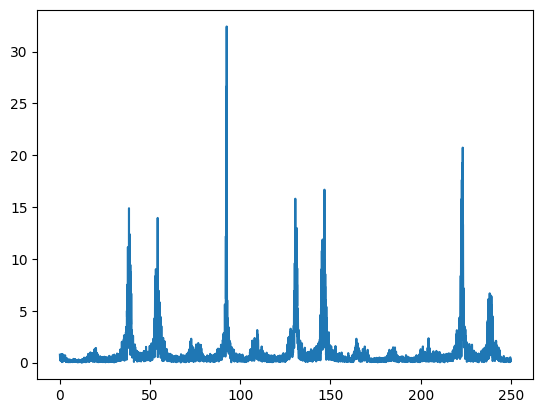

In [140]:
print(cD1.shape)
cD1_FFT = fft(cD1)
cD1_FFT = abs(cD1_FFT[:int(len(cD1)/2)]) # 取正頻率
f_d_level1 = sample_rate  / (2 * 1 ) / (len(cD1)) # 降取樣後的取樣頻率 fs/(2*2) / 降取樣後點數 len(cA2)
f_domain_level1 = np.arange(int(len(cD1)/2)) * f_d_level1
print(cD1_FFT.shape)
plt.plot(f_domain_level1, cD1_FFT)

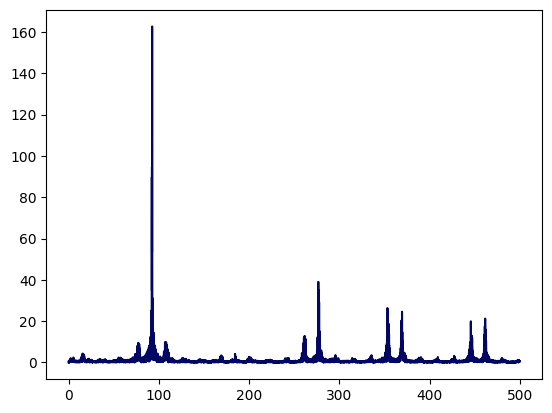

In [141]:
plt.plot(f_domain[:int(N/2)], BridgeDataOfAxis_FFT, color = 'xkcd:darkblue')
# plt.plot(cA2_FFT)
# plt.plot(cD2_FFT)
# plt.plot(cD1_FFT)

### **多層SWT轉換 - 沒有降取樣的DWT**

3
cA2.shape = (20000,)
cD2.shape = (20000,)
cD1.shape = (20000,)


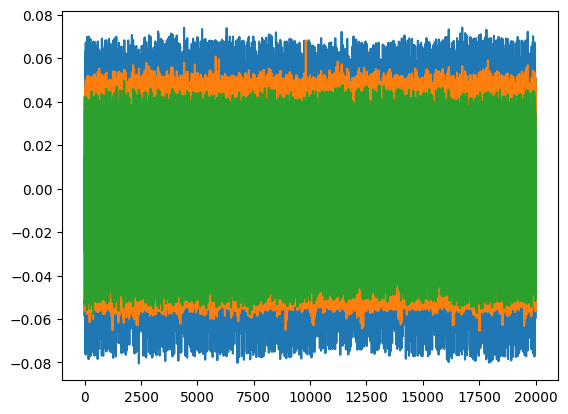

In [142]:
# SWT使用與DWT 相同規格的參數時，記得用 trim_approx = True
coeffs = pywt.swt(BridgeDataOfAxis, 'haar', level= 2, trim_approx = True) # DWT ， 二層分解， mode = periodic - 週期性的訊號 (∵訊號對稱)

print(len(coeffs))
cA2, cD2, cD1 = coeffs

print('cA2.shape =', cA2.shape)
print('cD2.shape =', cD2.shape)
print('cD1.shape =', cD1.shape)


plt.plot(cA2)
plt.plot(cD2)
plt.plot(cD1)

(20000,)
(10000,)
(20000,)
(10000,)
(20000,)
(10000,)


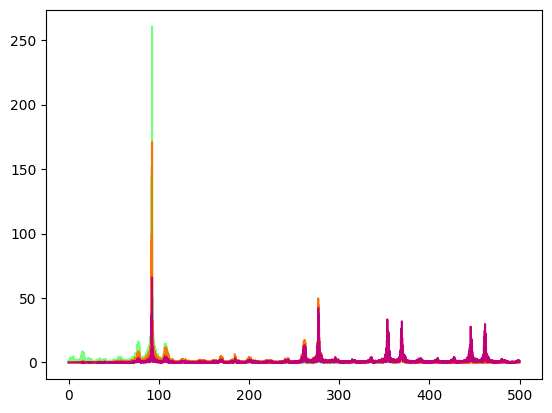

In [143]:
print(cA2.shape)
cA2_FFT = fft(cA2)
cA2_FFT = abs(cA2_FFT[:int(len(cA2_FFT)/2)])

print(cA2_FFT.shape)
plt.plot(f_domain[:int(N/2)], cA2_FFT, color = 'xkcd:lightgreen')

print(cD2.shape)
cD2_FFT = fft(cD2)
cD2_FFT = abs(cD2_FFT[:int(len(cD2_FFT)/2)])

print(cD2_FFT.shape)
plt.plot(f_domain[:int(N/2)], cD2_FFT, color = 'xkcd:orange')


print(cD1.shape)
cD1_FFT = fft(cD1)
cD1_FFT = abs(cD1_FFT[:int(len(cD1_FFT)/2)])

print(cD1_FFT.shape)
plt.plot(f_domain[:int(N/2)], cD1_FFT, color = 'xkcd:magenta')



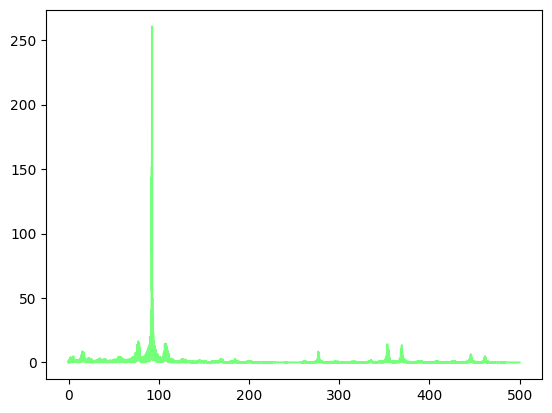

In [144]:
plt.plot(f_domain[:int(N/2)], cA2_FFT, color = 'xkcd:lightgreen')

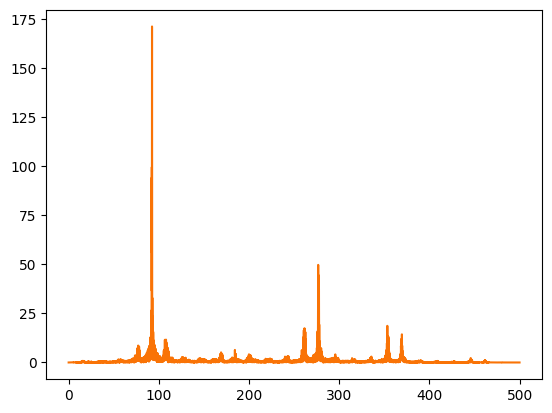

In [145]:
plt.plot(f_domain[:int(N/2)], cD2_FFT, color = 'xkcd:orange')

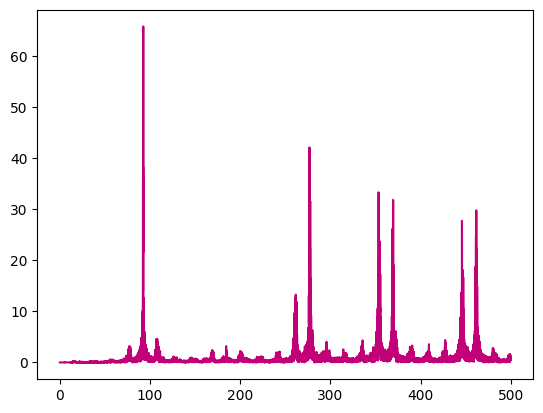

In [146]:
plt.plot(f_domain[:int(N/2)], cD1_FFT, color = 'xkcd:magenta')

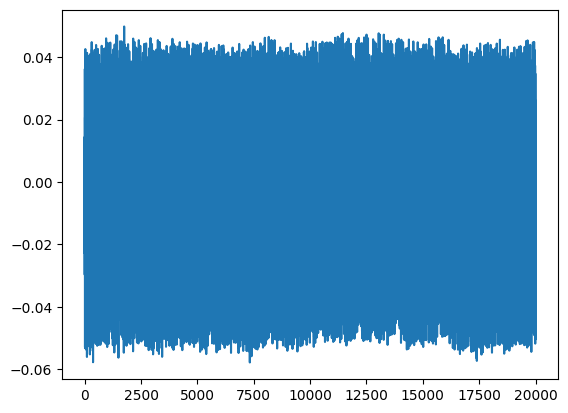

In [147]:
plt.plot(cD1)

### **驗證混疊效應**

將DWT、SWT分別得出的cD1後FFT

(10000,)
(5001,)


Text(0.5, 1.0, "FFT of DWT's cD1")

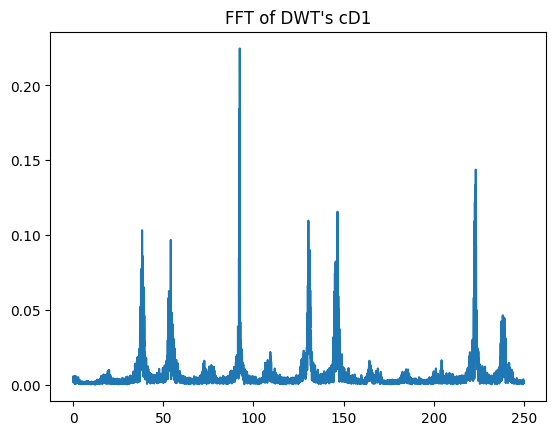

In [148]:
coeffs = pywt.wavedec(BridgeDataOfAxis, 'haar', level= 2) # DWT ， 二層分解， mode = periodic - 週期性的訊號 (∵訊號對稱)
cA2, cD2, cD1 = coeffs
print(cD1.shape)
DWT_cD1_FFT = fft(cD1)
DWT_cD1_FFT = abs(DWT_cD1_FFT[:(int(len(cD1)/2))+1]) # 取正頻率
# 頻域單位向量化
DWT_cD1_FFT = DWT_cD1_FFT / np.sqrt(np.sum(DWT_cD1_FFT**2))
f_d_level1 = f_d # 頻域取樣間隔 : 降取樣後的取樣頻率 fs/(2*2) / 降取樣後點數 len(cA2)
f_domain_level1 = np.arange((int(len(cD1)/2))+1) * f_d_level1
print(DWT_cD1_FFT.shape)
plt.plot(f_domain_level1, DWT_cD1_FFT)
plt.title('FFT of DWT\'s cD1')

(20000,)
(10001,)


Text(0.5, 1.0, "FFT of SWT's cD1")

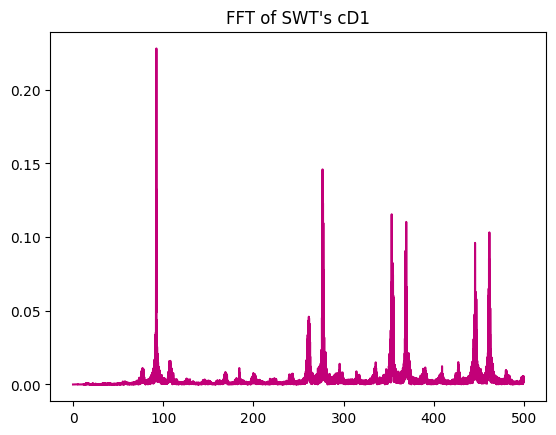

In [149]:
# SWT使用與DWT 相同規格的參數時，記得用 trim_approx = True
coeffs = pywt.swt(BridgeDataOfAxis, 'haar', level= 2, trim_approx = True) # DWT ， 二層分解， mode = periodic - 週期性的訊號 (∵訊號對稱)

cA2, cD2, cD1 = coeffs
print(cD1.shape)
SWT_cD1_FFT = fft(cD1)

SWT_cD1_FFT = abs(SWT_cD1_FFT[:(int((int(len(cD1)/2))+1))]) # 取正頻率
SWT_cD1_FFT = SWT_cD1_FFT / np.sqrt(np.sum(SWT_cD1_FFT**2))
f_d_level1 = f_d # 頻域取樣間隔 : 降取樣後的取樣頻率 fs/(2*2) / 降取樣後點數 len(cA2)
f_domain_level1 = np.arange(int((int(len(cD1)/2))+1)) * f_d_level1
print(SWT_cD1_FFT.shape)
plt.plot(f_domain_level1, SWT_cD1_FFT, color = 'xkcd:magenta')
plt.title('FFT of SWT\'s cD1')

#### **開始驗證**

**因為DWT降採樣兩倍，SWT沒有降採樣，代表Nyquist Frequency(fs)沒變**

**將SWT FFT後的頻譜 一半高頻部分(> fs/2 = SWT_cD1_FFT list 的後半段)取出並做水平翻轉**

**並與一半低頻部分(<fs/2, SWT_cD1_FFT list的前半段) 相加，並與DWT FFT做比較**

In [150]:
SWT_cD1_FFT_low_band = SWT_cD1_FFT[:int(len(SWT_cD1_FFT)/2)+1] # 0~Nyquist_Frquency
SWT_cD1_FFT_high_band = SWT_cD1_FFT[int(len(SWT_cD1_FFT)/2)+1:]

print(SWT_cD1_FFT_low_band.shape)
print(SWT_cD1_FFT_high_band.shape)


(5001,)
(5000,)


In [151]:
# 翻轉高頻訊號並相加
SWT_cD1_FFT_processed = SWT_cD1_FFT_low_band[:-1] + SWT_cD1_FFT_high_band[::-1] # 低頻不包含Nyquist Frequency的部分 + 高頻翻轉的部分
SWT_cD1_FFT_processed = np.append(SWT_cD1_FFT_processed, SWT_cD1_FFT_low_band[-1]) # 最後加上Nyquist Frequency的部分

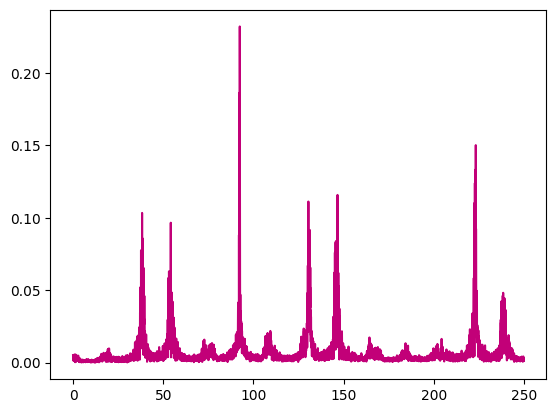

In [152]:
f_domain_level1 = np.arange(int(len(SWT_cD1_FFT_processed))) * f_d
plt.plot(f_domain_level1, SWT_cD1_FFT_processed, color = 'xkcd:magenta')

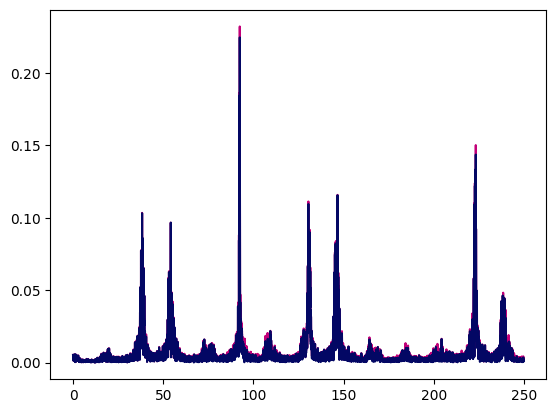

In [153]:
plt.plot(f_domain_level1, SWT_cD1_FFT_processed, color = 'xkcd:magenta')
plt.plot(f_domain_level1, DWT_cD1_FFT, color = 'xkcd:darkblue')
plt.show()